In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read and view the data
df = pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# Getting a grasp of how much data we are really working with
df.shape

(17880, 18)

In [ ]:
# Checking the sum of NaN's in each column
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Checking that column data types are coded correctly
df.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [9]:
# Let's check the target variable, whether a job post was determined to be fraudulent or not
df['fraudulent'].value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

As expected, we've got a heavily imbalanced dataset. Only about 5% of the data is classified as fraudulent. 

In [10]:
# Let's also check for any duplicates in the dataset
df.duplicated().sum()

np.int64(0)

In [11]:
# First clear cleaning step we can take is to drop the job_id column. No real meaning or predictive relevance for this project
df = df.drop(columns=['job_id'])

In [12]:
# I believe missingness in the data might be predictive. So I will add some missingness indicator columns for every column that has missing data and then fill
# the NaN's in the text/object columns with empty strings. Leaving numeric columns alone for now
missing_cols = df.columns[df.isna().any()]

for col in missing_cols:
    df[f"{col}_was_missing"] = df[col].isna().astype("int8")

In [14]:
# Now to fill the NaN's in the original columns with empty strings
obj_cols = df.select_dtypes(include=["object"]).columns
df[obj_cols] = df[obj_cols].fillna("")

In [16]:
# Now let's get an idea of distributions for the text columns. To do this, I'll make some new text length columns, get summary stats on them and then plot distributions
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    df[f"{col}_length"] = df[col].apply(len)

In [17]:
# Getting the summary stats
df[[f"{col}_length" for col in text_cols]].describe()

,title_length,company_profile_length,description_length,requirements_length,benefits_length
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,28.530313,620.901454,1218.004418,590.132215,208.895694
std,13.871256,567.454100,894.828620,613.191270,337.077357
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,138.000000,607.000000,146.000000,0.000000
50%,25.000000,570.000000,1017.000000,467.000000,45.000000
75%,35.000000,879.000000,1586.000000,820.000000,294.000000
max,142.000000,6178.000000,14907.000000,10864.000000,4429.000000


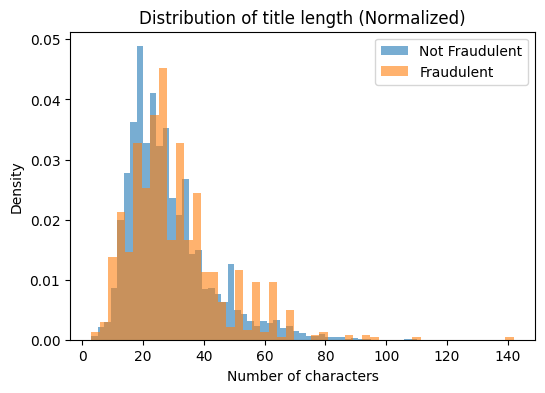

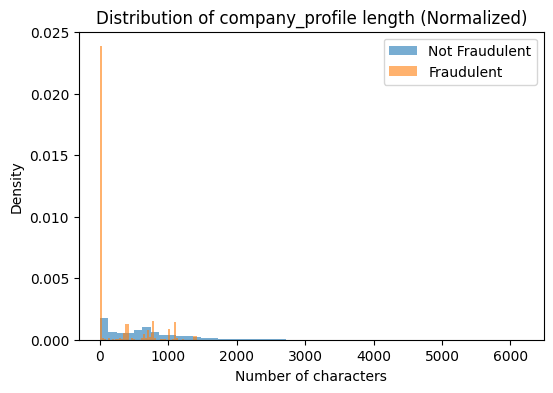

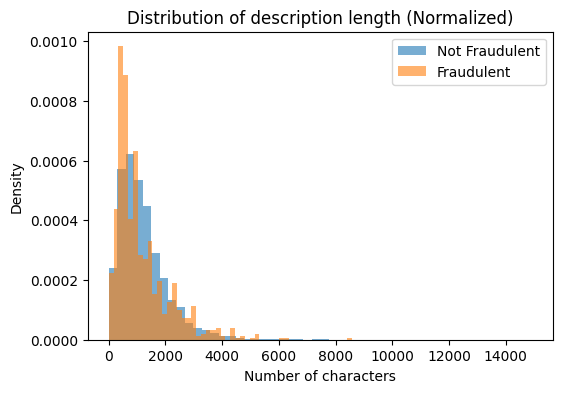

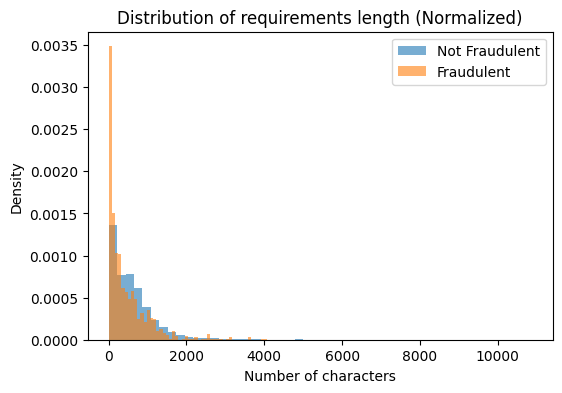

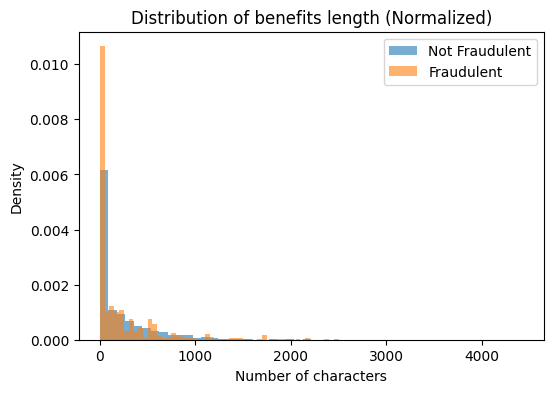

In [19]:
# Now to compare distributions of these text columns by the fraudulent label
for col in text_cols:
    plt.figure(figsize=(6,4))
    df[df["fraudulent"] == 0][f"{col}_length"].plot(
        kind="hist", bins=50, alpha=0.6, density=True, label="Not Fraudulent"   # I will be using density histograms because of the class imbalance
    )
    df[df["fraudulent"] == 1][f"{col}_length"].plot(
        kind="hist", bins=50, alpha=0.6, density=True, label="Fraudulent"
    )
    plt.title(f"Distribution of {col} length (Normalized)")
    plt.xlabel("Number of characters")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

So it looks as though many of the fraudulent posts have little or no information for several of these text columns. Particularly, company_profile_length may be an especially powerful predictor for my models, as hardly any fraudulent posts actually had a company profile.

In [22]:
# I would bet that fraudulent job posts likely sound different than ordinary, legit posts. Let's get some word counts for fraudulent and legit posts and see if any words
# appear disproportionately in either classification.

# First, we'll need to do some processing of the text variables:
from collections import Counter
import re

# Lowercase everything, remove non-alphabetic characters, split on spaces
def tokenize(text):
    words = re.findall(r'\b[a-z]{5,}\b', text.lower()) # finding and keeping all words greater than and equal to 5 letters in length
    return words

In [23]:
# Calling our tokenize function on fraudulent and legit posts' job descriptions, to start
fraud_words = Counter()
real_words = Counter()

for text in df[df["fraudulent"] == 1]["description"]:
    fraud_words.update(tokenize(text))
for text in df[df["fraudulent"] == 0]["description"]:
    real_words.update(tokenize(text))

# Taking a peek at the most frequent words in fraudulent and legit posts 
print("Top words in fraudulent descriptions:", fraud_words.most_common(20))
print("Top words in real descriptions:", real_words.most_common(20))

Top words in fraudulent descriptions: [('experience', 496), ('company', 491), ('position', 477), ('management', 464), ('project', 454), ('customer', 453), ('service', 449), ('business', 448), ('looking', 434), ('skills', 426), ('support', 384), ('other', 380), ('engineering', 371), ('services', 350), ('solutions', 340), ('within', 323), ('equipment', 317), ('product', 315), ('provide', 303), ('systems', 301)]
Top words in real descriptions: [('business', 10474), ('experience', 9956), ('company', 9706), ('customer', 9428), ('sales', 9327), ('looking', 8346), ('development', 7967), ('management', 7361), ('product', 7212), ('their', 6899), ('marketing', 6761), ('service', 6751), ('support', 6304), ('other', 6266), ('design', 6041), ('client', 6024), ('services', 5923), ('working', 5826), ('position', 5676), ('clients', 5461)]


In [24]:
# That wasn't as insightful as I had hoped. Let's get a relative word frequency comparison
fraud_total = sum(fraud_words.values())
real_total = sum(real_words.values())

# Calculating the normalized frequency
fraud_freq = {w: c/fraud_total for w, c in fraud_words.items()}
real_freq = {w: c/real_total for w, c in real_words.items()}

# The words that are disproportionately frequent in fraudulent posts
diff = {w: fraud_freq.get(w,0) - real_freq.get(w,0) for w in fraud_freq}
sorted(diff.items(), key=lambda x: x[1], reverse=True)[:20]

[('engineering', 0.003441088287385953),
 ('equipment', 0.0032084965965455347),
 ('project', 0.003057467630486634),
 ('position', 0.0026015634992535377),
 ('skills', 0.0023434003292701912),
 ('within', 0.002128631616673214),
 ('solutions', 0.002053292664121637),
 ('systems', 0.0020492360382285612),
 ('maintenance', 0.001835315125898865),
 ('information', 0.0017505011266148493),
 ('entry', 0.0017153050878575917),
 ('field', 0.0015907961752458285),
 ('service', 0.0015445888575082722),
 ('perform', 0.0014433290130315222),
 ('administrative', 0.0014297798159489845),
 ('required', 0.0013881450360465624),
 ('industry', 0.0013849827629131273),
 ('management', 0.0013493058611278568),
 ('needed', 0.001301462647099912),
 ('safety', 0.0012611683031606498)]

So it does appear that fraudulent job posts in this data set sound different in their job descriptions. For example, the word "engineering" appears 3.4 times more often per 1000 words than in legit job posts. This suggests it would be worth exploring the tokenized words more deeply in the other text variables to get a better feel for how fake job posts might sound.

In [25]:
# Let's turn that previous code into a consolidated function so I can call it for the other text variables easily.

def compare_word_freq(df, column, top_n=20, min_word_len=5):
    def tokenize(text):
        words = re.findall(r'\b[a-z]{%d,}\b' % min_word_len, text.lower()) # same as before, preprocessing the text column
        return words
    
    fraud_words = Counter()
    real_words = Counter()
    
    for text in df[df["fraudulent"] == 1][column]:
        fraud_words.update(tokenize(text))
    for text in df[df["fraudulent"] == 0][column]:
        real_words.update(tokenize(text))
    
    fraud_total = sum(fraud_words.values())
    real_total = sum(real_words.values())
    
    fraud_freq = {w: c/fraud_total for w, c in fraud_words.items()}
    real_freq = {w: c/real_total for w, c in real_words.items()}
    
    # Computing the differences
    diff = {w: fraud_freq.get(w,0) - real_freq.get(w,0) for w in fraud_freq}
    
    # Sorting by absolute difference, the words that seem to stand out the most
    sorted_diff = sorted(diff.items(), key=lambda x: abs(x[1]), reverse=True)
    
    return sorted_diff[:top_n]

In [26]:
# Now to call this consolidated function for other text columns. Let's start with requirements
compare_word_freq(df, "requirements", top_n=20)

[('skills', 0.005890140092412718),
 ('engineering', 0.003945962664720293),
 ('computer', 0.0039211803404670025),
 ('ability', 0.0036796931706131516),
 ('office', 0.003228423506504616),
 ('internet', 0.0029357588519931567),
 ('qualifications', 0.00285638799022551),
 ('marketing', -0.0025247471585075404),
 ('equipment', 0.0021556427401017127),
 ('business', -0.0021104428919504706),
 ('environment', 0.002077778433010432),
 ('system', 0.0020657289924162965),
 ('industry', 0.0019352930055166748),
 ('social', -0.0018732962102480655),
 ('sales', -0.0018586862218465975),
 ('personal', 0.001845467347361687),
 ('microsoft', 0.0018190873398761151),
 ('email', 0.0017902409521646121),
 ('requirements', 0.0017455513648343321),
 ('typing', 0.0017331009839193826)]

In [27]:
compare_word_freq(df, "company_profile", top_n=20)

[('candidates', 0.011101197851335549),
 ('bonus', 0.009539545321578934),
 ('recruiting', 0.009449687105417855),
 ('staffing', 0.007620411167622548),
 ('referral', 0.007315251004456256),
 ('signing', 0.007203085291807743),
 ('aptitude', 0.0070478299078415565),
 ('career', 0.00629758727388737),
 ('industry', 0.005466515902063915),
 ('refined', 0.00521718836793431),
 ('leveraging', 0.005142817623678231),
 ('professional', 0.005105182374831053),
 ('financing', 0.005023664180924764),
 ('world', -0.004890146627067932),
 ('resources', 0.004690260278172351),
 ('products', 0.004659285334362353),
 ('receive', 0.004448588634245356),
 ('accion', 0.004234484583829562),
 ('experience', 0.004221685724269708),
 ('enjoy', 0.004092584415839207)]

In [28]:
compare_word_freq(df, "benefits", top_n=20)

[('benefits', 0.008835233550189874),
 ('started', 0.006940165863392698),
 ('entry', 0.006571662050411041),
 ('start', 0.006540765818494947),
 ('employee', 0.006539566312372936),
 ('training', 0.006171876124939897),
 ('skills', 0.005986907063043799),
 ('colleagues', 0.005777659985103584),
 ('world', 0.004681347490047774),
 ('complete', 0.004646489308219322),
 ('environment', 0.004619555026215587),
 ('encouraged', 0.00437961588115951),
 ('online', 0.004245515101139701),
 ('level', 0.00420478801555899),
 ('company', 0.004180487550487805),
 ('culture', 0.004177297361722234),
 ('available', 0.004135435083448411),
 ('events', 0.003859673055130398),
 ('position', 0.0038193206256095466),
 ('customers', 0.003776516094929309)]

In [35]:
# Before moving on to cleaning numeric columns, I'm going to remove stop words and lemmatize the text variables so that they will be more easily used in model building step
# Build a stopword set with negations kept

import re

# Defining negations and stopwords
NEGATIONS = {"no", "not", "nor", "n't", "never", "none", "neither", "cannot"}
stop = {
    "the","a","an","and","or","but","if","then","so","than","to","of","in","on","for","with","as","by","from","at",
    "is","are","was","were","be","been","being","this","that","these","those","it","its","i","you","we","they","he","she"
}
# Keeping negations
STOPWORDS = {w for w in stop if w not in NEGATIONS}

# Making a simple cleaner function
def remove_stopwords(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Keeping only alphabetic words (remove digits, punctuation)
    words = re.findall(r"[a-z']+", text)
    # Dropping stopwords but keep negations
    words = [w for w in words if (w not in STOPWORDS) or (w in NEGATIONS)]
    return " ".join(words)

# Applying to the text columns
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]
for col in text_cols:
    if col in df.columns:
        df[f"{col}_nostop"] = df[col].fillna("").apply(remove_stopwords)

# Making a new column that contains all text fields in one. The models I build won't care what columns the text comes from and this will make my pipeline simpler
df["text_all_nostop"] = df[[f"{c}_nostop" for c in text_cols if f"{c}_nostop" in df.columns]].agg(" ".join, axis=1)

# Check to make sure it all went okay!
df[[c for c in df.columns if c.endswith("_nostop")]].head()

,title_nostop,company_profile_nostop,description_nostop,requirements_nostop,benefits_nostop,text_all_nostop
0,marketing intern,we're food we've created groundbreaking award ...,food fast growing james beard award winning on...,experience content management systems major pl...,,marketing intern we're food we've created grou...
1,customer service cloud video production,seconds worlds cloud video production service ...,organised focused vibrant awesome do have pass...,what expect your key responsibility will commu...,what will get usthrough part seconds team will...,customer service cloud video production second...
2,commissioning machinery assistant cma,valor services provides workforce solutions me...,our client located houston actively seeking ex...,implement pre commissioning commissioning proc...,,commissioning machinery assistant cma valor se...
3,account executive washington dc,our passion improving quality life through geo...,company esri environmental systems research in...,education bachelor s master s gis business adm...,our culture anything corporate have collaborat...,account executive washington dc our passion im...
4,bill review manager,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualifications rn license state texasdiploma b...,full benefits offered,bill review manager spotsource solutions llc g...


In [36]:
# Now let's get our TF-IDF set up which we will need later on for modeling. 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# First, setting up train-test split (stratify so fraud ratio is preserved)
X_train, X_test, y_train, y_test = train_test_split(
    df["text_all_nostop"], df["fraudulent"],
    test_size=0.2, random_state=18, stratify=df["fraudulent"]
)

In [37]:
# Initializing TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,   # top 10k words
    ngram_range=(1,2),    # unigrams + bigrams
    min_df=5              # only keep words that appear in 5 or more docs
)

# Fitting on training set, transform both train & test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("Shape of TF-IDF train matrix:", X_train_tfidf.shape)
print("Shape of TF-IDF test matrix:", X_test_tfidf.shape)

Shape of TF-IDF train matrix: (14304, 10000)
Shape of TF-IDF test matrix: (3576, 10000)


In [41]:
# salary_range will need to be parsed and cleaned to be available for my models so let's take care of that now

# Parse a salary_range like "50000-70000". Returns (min_salary, max_salary)
def parse_salary_range(s):
    if not isinstance(s, str) or s.strip() == "":
        return (np.nan, np.nan)
    
    parts = s.split("-")
    if len(parts) == 2:
        low = parts[0].strip()
        high = parts[1].strip()
        try:
            low_val = float(low) if low else np.nan
        except:
            low_val = np.nan
        try:
            high_val = float(high) if high else np.nan
        except:
            high_val = np.nan
        return (low_val, high_val)
    else:
        return (np.nan, np.nan)

# Applying this parsing function to dataset
df[["min_salary", "max_salary"]] = df["salary_range"].apply(lambda x: pd.Series(parse_salary_range(x)))

# Derived features
df["avg_salary"] = df[["min_salary", "max_salary"]].mean(axis=1)
df["range_salary"] = df["max_salary"] - df["min_salary"]

# Handling the NaN values we introduced (keeping the salary_range_was_missing flag for model awareness)
for col in ["min_salary", "max_salary", "avg_salary", "range_salary"]:
    df[col] = df[col].fillna(df[col].median())

df[["salary_range", "min_salary", "max_salary", "avg_salary", "range_salary"]].head(10)

,salary_range,min_salary,max_salary,avg_salary,range_salary
0,,35000.0,50000.0,44000.0,10000.0
1,,35000.0,50000.0,44000.0,10000.0
2,,35000.0,50000.0,44000.0,10000.0
3,,35000.0,50000.0,44000.0,10000.0
4,,35000.0,50000.0,44000.0,10000.0
5,,35000.0,50000.0,44000.0,10000.0
6,20000-28000,20000.0,28000.0,24000.0,8000.0
7,,35000.0,50000.0,44000.0,10000.0
8,,35000.0,50000.0,44000.0,10000.0
9,,35000.0,50000.0,44000.0,10000.0


In [45]:
# Lastly, to handle and clean the categorical columns. I think I'll just drop location entirely. It is messy and likely not worth the amount of time I would have to
# spend processing it. So let's just one-hot encode all the other categorical columns, grouping infrequent values into an "other" column so we can avoid exploding the data

from sklearn.preprocessing import OneHotEncoder

# Choosing categorical columns to encode
cat_cols = ["employment_type", "required_experience", "required_education", "department", "industry", "function"]

# Replacing NaN with "Missing"
df[cat_cols] = df[cat_cols].fillna("Missing")

# Grouping rare categories into "Other"
def group_rare(series, min_freq=50):
    counts = series.value_counts()
    return series.apply(lambda x: x if counts[x] >= min_freq else "Other")

for col in ["department", "industry", "function"]:
    if col in df.columns:
        df[col] = group_rare(df[col], min_freq=50)

# Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Fit and transform with ohe
encoded = ohe.fit_transform(df[cat_cols])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

# Concatenating it back to main df
df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

print("Shape after encoding:", df.shape)

Shape after encoding: (17880, 163)


In [86]:
# Last step is to combine our structured data columns with the TF-IDF we made before

# Separate target
y = df["fraudulent"]

# Drop target + raw text columns + salary_range
drop_cols = [
    "fraudulent", "title", "company_profile", "description", 
    "requirements", "benefits", "salary_range",
    "title_nostop", "company_profile_nostop", 
    "description_nostop", "requirements_nostop", 
    "benefits_nostop", "text_all_nostop"
]

X_struct = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Structured feature shape:", X_struct.shape)

Structured feature shape: (17880, 150)


In [87]:
# Columns to combine
text_cols = [
    "title_nostop", "company_profile_nostop",
    "description_nostop", "requirements_nostop",
    "benefits_nostop"
]

# Ensure all are strings
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

# Build combined text
df["text_all_nostop"] = df[text_cols].agg(" ".join, axis=1)

# Sanity check
print(df["text_all_nostop"].head().tolist())
print("Unique dtypes:", df["text_all_nostop"].map(type).unique())

["marketing intern we're food we've created groundbreaking award winning cooking site support connect celebrate home cooks give them everything need one place have top editorial business engineering team we're focused using technology find new better ways connect people around their specific food interests offer them superb highly curated information about food cooking attract most talented home cooks contributors country also publish well known professionals like mario batali gwyneth paltrow danny meyer have partnerships whole foods market random house food has named best food website james beard foundation iacp has featured new york times npr pando daily techcrunch today show we're located chelsea new york city food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid interns work small team editors executives developers new york city headquarters reproducing repackaging existing food content number

In [88]:
# Train/test split, stratified
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=18, stratify=df["fraudulent"]
)

X_train_struct = X_struct.loc[train_idx]
X_test_struct  = X_struct.loc[test_idx]
X_train_text   = df.loc[train_idx, "text_all_nostop"].astype(str)
X_test_text    = df.loc[test_idx, "text_all_nostop"].astype(str)
y_train        = y.loc[train_idx]
y_test         = y.loc[test_idx]

# Sanity check
print("Train text types:", X_train_text.map(type).unique())
print("Example docs:", X_train_text.head().tolist())

Train text types: [<class 'str'>]
Example docs: ['production operations manager dairy food beverage processors work within one most complex competitive precision driven industries need partner can rely address their operational issues w m sprinkman has providing system design engineering installation well stainless steel manufacturing maintenance servicing equipment over years secret foundation core our longevity our incredibly talented dedicated staff sales service concepts installation w m sprinkman premier provider custom solutions dairy food beverage industries looking skilled operations manager lead production elroy plant outstanding opportunity someone great business people skills direct indirect supervision shift plus person operation initially capacity significant growthplanning direct oversee entire elroy production process achieve exceed production quality safety profitability goals objectives apply lean manufacturing initiatives improve operating efficiency control labor cos

In [90]:
tfidf = TfidfVectorizer(
    max_features=10000,   # limit vocab size
    ngram_range=(1,2),    # unigrams + bigrams
    min_df=5              # only keep words in >=5 docs
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

print("TF-IDF vocab size:", len(tfidf.get_feature_names_out()))
print("TF-IDF train shape:", X_train_tfidf.shape)

TF-IDF vocab size: 10000
TF-IDF train shape: (14304, 10000)


In [91]:
# Now it is time to combine our structured and sparse (tfidf) together to make final train/test matrices that can be used in the models

from scipy.sparse import hstack, csr_matrix

# Convert structured to sparse
X_train_struct_sparse = csr_matrix(X_train_struct.values)
X_test_struct_sparse  = csr_matrix(X_test_struct.values)

# Combine
X_train_final = hstack([X_train_struct_sparse, X_train_tfidf])
X_test_final  = hstack([X_test_struct_sparse, X_test_tfidf])

print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)

Final train shape: (14304, 10150)
Final test shape: (3576, 10150)


In [ ]:
# We're ready to run our first model. Let's just start with a logistic regression. We'll have to standardize the numeric cols since we didn't do that before

from sklearn.preprocessing import StandardScaler

# Identify numeric columns
num_cols = X_struct.select_dtypes(include=["int64", "float64"]).columns

# Fit scaler on training numeric features
scaler = StandardScaler(with_mean=False)  # with_mean=False keeps sparse compatibility
scaler.fit(X_train_struct[num_cols])

# Transform train/test numeric features
X_train_num_scaled = scaler.transform(X_train_struct[num_cols])
X_test_num_scaled  = scaler.transform(X_test_struct[num_cols])

# Convert non-numeric structured features back to sparse
X_train_other = X_train_struct.drop(columns=num_cols)
X_test_other  = X_test_struct.drop(columns=num_cols)

X_train_other_sparse = csr_matrix(X_train_other.values)
X_test_other_sparse  = csr_matrix(X_test_other.values)

# Combine scaled numerics + other structured + TF-IDF
X_train_final_scaled = hstack([X_train_num_scaled, X_train_other_sparse, X_train_tfidf])
X_test_final_scaled  = hstack([X_test_num_scaled, X_test_other_sparse, X_test_tfidf])

print("Scaled train shape:", X_train_final_scaled.shape)
print("Scaled test shape:", X_test_final_scaled.shape)

Scaled train shape: (14304, 10150)
Scaled test shape: (3576, 10150)


In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initializing the Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,       # ensure convergence
    solver="saga",  # better for large, sparse structured + tfidf 
    class_weight="balanced"  # handle fraud imbalance
)

# Fit model
log_reg.fit(X_train_final_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_final_scaled)
y_proba = log_reg.predict_proba(X_test_final_scaled)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[3005  398]
 [  16  157]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.94      3403
           1       0.28      0.91      0.43       173

    accuracy                           0.88      3576
   macro avg       0.64      0.90      0.68      3576
weighted avg       0.96      0.88      0.91      3576

ROC-AUC Score: 0.9426789351116576


c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


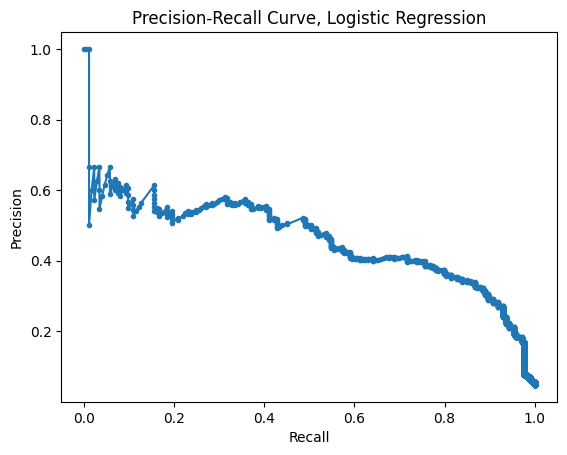

Best threshold: 0.7487956715181746
Precision at best threshold: 0.41333333333333333
Recall at best threshold: 0.7167630057803468
F1 at best threshold: 0.5243128959419654


In [ ]:
# Let's get a precision-recall curve for this model to see what the optimal threshold might be for our needs
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_proba = log_reg.predict_proba(X_test_final_scaled)[:, 1]

# Compute precision-recall curve using sklearn's metrics
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plotting the result for interpretability
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, Logistic Regression")
plt.show()

# Find the threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision at best threshold:", precision[best_idx])
print("Recall at best threshold:", recall[best_idx])
print("F1 at best threshold:", f1_scores[best_idx])

Pleasantly surprised with the performance of even the baseline logistic regression with a decision threshold of 0.5! I may adjust the decision threshold to show how it can be used for different needs (job-seekers with different tolerances, HR professionals). But for now, this serves as a great proof-of-concept with a non-trivial result.

In [97]:
# Random Forest Model
# To compliment the linear regression model, let's run a random forest that might capture some aspects of the data that the logistic regression did not. 
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees, 200 to start (not sure where a sweet spot would be, but let's start here)
    max_depth=None,          # letting the trees expand fully
    class_weight="balanced", # handling the fraudulent class imbalance
    n_jobs=-1,               # use all CPU cores if needed
    random_state=18
)

# Fitting the model
rf.fit(X_train_final, y_train)

# Making our predictions using this model
y_pred_rf = rf.predict(X_test_final)
y_proba_rf = rf.predict_proba(X_test_final)[:, 1]

# Evaluations
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

Confusion Matrix:
 [[3401    2]
 [  80   93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.98      0.54      0.69       173

    accuracy                           0.98      3576
   macro avg       0.98      0.77      0.84      3576
weighted avg       0.98      0.98      0.97      3576

ROC-AUC Score: 0.9859661400430426


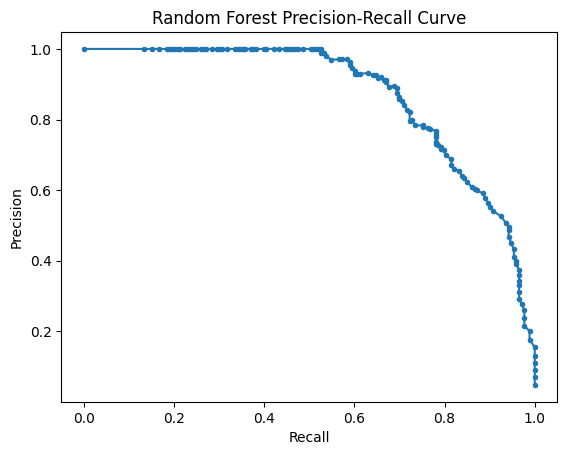

Best threshold: 0.345
Precision at best threshold: 0.8888888888888888
Recall at best threshold: 0.6936416184971098
F1 at best threshold: 0.77922077872839


In [98]:
# Again, let's get another precision-recall curve to see the tradeoff and how a different decision threshold might change our results

# Predicted probabilities (fraud class = 1)
y_proba_rf = rf.predict_proba(X_test_final)[:, 1]

# Computing precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

# Plotting the curve
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest Precision-Recall Curve")
plt.show()

# Finding threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision at best threshold:", precision[best_idx])
print("Recall at best threshold:", recall[best_idx])
print("F1 at best threshold:", f1_scores[best_idx])

This is an even better result than logistic regression, as I expected. I am a little suspicious of the extremely high ROC-AUC score of 0.98. I checked my preprocessing and cleaning and didn't see any way I could have data leakage but just out of caution, I'm going to check feature importances. If there are a lot of "_missing" type variables in the top features, I might suspect leakage is still happening somehow (possibly with how the original variables were encoded in the first place).

In [100]:
# Getting RF importances
importances = rf.feature_importances_

# Building feature name list:
# Structured feature names
struct_feature_names = list(X_struct.columns)

# TF-IDF feature names
tfidf_feature_names = tfidf.get_feature_names_out().tolist()

# Combined feature names
all_feature_names = struct_feature_names + tfidf_feature_names

# Pairing the feature names with importances
feat_importances = sorted(
    zip(all_feature_names, importances),
    key=lambda x: x[1],
    reverse=True
)

# Printing the top 10
print("Top 10 important features for Random Forest:")
for name, score in feat_importances[:10]:
    print(f"{name:30} {score:.4f}")

Top 10 important features for Random Forest:
company_profile_was_missing    0.0302
company_profile_length         0.0280
has_company_logo               0.0177
our                            0.0113
web                            0.0061
growing                        0.0056
entry                          0.0055
mobile                         0.0048
work home                      0.0045
requirements_length            0.0041
